<a href="https://colab.research.google.com/github/varundubey2804/Stress_Level_Prediction/blob/main/MLP_hrv_swell_all_samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv('/content/all-samples.csv')

In [ ]:
df = df.dropna()

In [ ]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
def cap_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data.apply(lambda x: np.where(x < lower_bound[x.name], lower_bound[x.name], x))
    data = data.apply(lambda x: np.where(x > upper_bound[x.name], upper_bound[x.name], x))
    return data

df = cap_outliers_iqr(df)

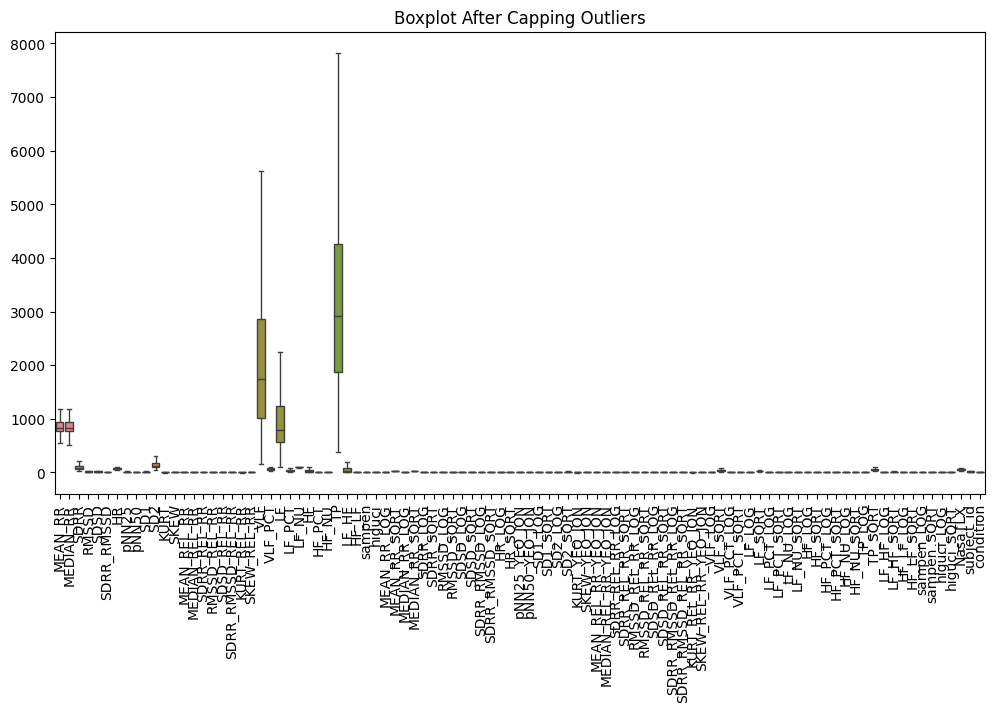

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot After Capping Outliers")
plt.show()

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [ ]:
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
num_features_to_select = 10
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X_new = selector.fit_transform(X, y)

In [ ]:
selected_feature_names = X.columns[selector.get_support()].tolist()
print(f"Selected Features: {selected_feature_names}")

Selected Features: ['MEAN_RR', 'MEDIAN_RR', 'HR', 'MEAN_RR_LOG', 'MEAN_RR_SQRT', 'MEDIAN_RR_LOG', 'MEDIAN_RR_SQRT', 'HR_LOG', 'HR_SQRT', 'HF_PCT_SQRT']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)


In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from tensorflow.keras.utils import to_categorical
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
EPOCHS = 50
BATCH_SIZE = 32
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.4698 - loss: 1.1501 - val_accuracy: 0.6084 - val_loss: 0.8987
Epoch 2/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5329 - loss: 0.9742 - val_accuracy: 0.6252 - val_loss: 0.8593
Epoch 3/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5619 - loss: 0.9312 - val_accuracy: 0.6451 - val_loss: 0.8358
Epoch 4/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5781 - loss: 0.9038 - val_accuracy: 0.6544 - val_loss: 0.7984
Epoch 5/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5871 - loss: 0.8811 - val_accuracy: 0.6511 - val_loss: 0.7794
Epoch 6/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5997 - loss: 0.8603 - val_accuracy: 0.6697 - val_loss: 0.7590
Epoch 7/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6146 - loss: 0.8473 - val_accuracy: 0.6650 - val_loss: 0.7595
Epoch 8/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6148 - loss: 0.8348 - val_accuracy: 

In [ ]:

def build_model(hp):
    model = Sequential()

    # First Dense Layer
    model.add(Dense(hp.Int('units_1', min_value=64, max_value=256, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Second Dense Layer
    model.add(Dense(hp.Int('units_2', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Third Dense Layer
    model.add(Dense(hp.Int('units_3', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
!pip install keras-tuner -q
from keras_tuner import Hyperband #Import the Hyperband class from keras_tuner
#... (rest of the code remains the same)
tuner = Hyperband( # Start hyperparameter tuning using Hyperband
    build_model,
    objective='val_accuracy',
    max_epochs=100,
    factor=2,
    directory='mlp_tuner',
    project_name='mlp_hyperparam_tuning'
)

Reloading Tuner from mlp_tuner/mlp_hyperparam_tuning/tuner0.json


In [ ]:
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, verbose=1)


Trial 90 Complete [00h 01m 44s]
val_accuracy: 0.6444991827011108

Best val_accuracy So Far: 0.8411329984664917
Total elapsed time: 00h 53m 08s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest Hyperparameters: {best_hps.values}")


Best Hyperparameters: {'units_1': 224, 'dropout_1': 0.1, 'units_2': 128, 'dropout_2': 0.1, 'units_3': 64, 'dropout_3': 0.1, 'learning_rate': 0.001, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0077'}


In [ ]:
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5035 - loss: 1.0519 - val_accuracy: 0.6273 - val_loss: 0.8453
Epoch 2/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5887 - loss: 0.8863 - val_accuracy: 0.6628 - val_loss: 0.7651
Epoch 3/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6084 - loss: 0.8488 - val_accuracy: 0.6800 - val_loss: 0.7237
Epoch 4/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6278 - loss: 0.8064 - val_accuracy: 0.6700 - val_loss: 0.7152
Epoch 5/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6389 - loss: 0.7894 - val_accuracy: 0.6956 - val_loss: 0.6808
Epoch 6/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6531 - loss: 0.7611 - val_accuracy: 0.7089 - val_loss: 0.6607
Epoch 7/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6663 - loss: 0.7439 - val_accuracy: 0.7192 - val_loss: 0.6385
Epoch 8/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6792 - loss: 0.7161 - val_accu

In [ ]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8888 - loss: 0.2959

Test Accuracy: 88.07%


In [ ]:
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.87      1602
           1       0.87      0.88      0.87      1636
           2       0.88      0.91      0.90      1634

    accuracy                           0.88      4872
   macro avg       0.88      0.88      0.88      4872
weighted avg       0.88      0.88      0.88      4872

